In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio


2024-07-31 09:48:29.531879: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 09:48:29.539646: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 09:48:29.563002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 09:48:29.601583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 09:48:29.612703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 09:48:29.637808: I tensorflow/core/platform/cpu_feature_gu

In [4]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav


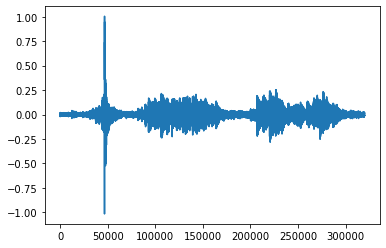

In [7]:
testing_wav_data = load_wav_16k_mono('/home/focus/Bureau/Audio_Node/recordings/music1')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)


In [8]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)


645627904/Unknown 335s 1us/step

In [15]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()



,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [14]:
# my_classes = ['Music', 'Beep','Speech','Silence']
# map_class_to_id = {'Music':0, 'Beep':1, 'Speech':2, 'Silence':3}
my_classes = ['music']
map_class_to_id = {'music':0}



filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)


,filename,fold,target,category,esc10,src_file,take


# feature extractor

In [3]:
model = tf.saved_model.load("/home/focus/Bureau/Audio_Node/ray_audio/yamnet_ray")


In [9]:
import pyaudio

p = pyaudio.PyAudio()

for i in range(p.get_device_count()):
    info = p.get_device_info_by_index(i)
    print(f"Device ID {i}: {info['name']}, Channels: {info['maxInputChannels']}")

p.terminate()


Device ID 0: HDA Intel HDMI: 0 (hw:0,3), Channels: 0
Device ID 1: HDA Intel HDMI: 1 (hw:0,7), Channels: 0
Device ID 2: HDA Intel HDMI: 2 (hw:0,8), Channels: 0
Device ID 3: HDA Intel PCH: ALC3232 Analog (hw:1,0), Channels: 2
Device ID 4: EPOS IMPACT 60: USB Audio (hw:2,0), Channels: 1
Device ID 5: hdmi, Channels: 0
Device ID 6: pulse, Channels: 32
Device ID 7: default, Channels: 32


ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


In [2]:
import pyaudio

def get_default_input_device():
    p = pyaudio.PyAudio()
    
    default_device_index = p.get_default_input_device_info()["index"]
    default_device_info = p.get_device_info_by_index(default_device_index)
    
    print("Default Input Device Info:")
    print(f"Device Index: {default_device_index}")
    print(f"Device Name: {default_device_info['name']}")
    print(f"Max Input Channels: {default_device_info['maxInputChannels']}")
    print(f"Default Sample Rate: {default_device_info['defaultSampleRate']}")
    
    p.terminate()

if __name__ == "__main__":
    get_default_input_device()


Default Input Device Info:
Device Index: 7
Device Name: default
Max Input Channels: 32
Default Sample Rate: 44100.0


ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


In [13]:
import pyaudio
import wave

def list_input_devices(p):
    print("Available input devices:")
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)
        if device_info['maxInputChannels'] > 0:
            print(f"Device ID: {i}, Device Name: {device_info['name']}")

def record_audio(device_index, duration, output_filename):
    p = pyaudio.PyAudio()

    # Set up the audio stream
    chunk = 1024  # Record in chunks of 1024 samples
    format = pyaudio.paInt16  # 16-bit resolution
    channels = 1  # Mono
    rate = 44100  # Sample rate in Hz

    stream = p.open(format=format,
                    channels=channels,
                    rate=rate,
                    input=True,
                    
                    frames_per_buffer=chunk,
                    input_device_index=device_index,)

    print("Recording...")

    frames = []

    for _ in range(0, int(rate / chunk * duration)):
        data = stream.read(chunk)
        frames.append(data)

    print("Recording finished.")

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    p.terminate()

    # Save the recorded audio to a file
    with wave.open(output_filename, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(p.get_sample_size(format))
        wf.setframerate(rate)
        wf.writeframes(b''.join(frames))


In [4]:
p = pyaudio.PyAudio()

In [5]:
list_input_devices(p)

Available input devices:
Device ID: 3, Device Name: HDA Intel PCH: ALC3232 Analog (hw:1,0)
Device ID: 5, Device Name: pulse
Device ID: 6, Device Name: default


In [5]:
record_audio(7,5,'/home/focus/Bureau/Audio_Node/recordings/device7')

Recording...
Recording finished.


In [1]:
import sounddevice as sd
print (sd.query_devices() )

  0 HDA Intel HDMI: 0 (hw:0,3), ALSA (0 in, 8 out)
  1 HDA Intel HDMI: 1 (hw:0,7), ALSA (0 in, 8 out)
  2 HDA Intel HDMI: 2 (hw:0,8), ALSA (0 in, 8 out)
  3 HDA Intel PCH: ALC3232 Analog (hw:1,0), ALSA (2 in, 4 out)
  4 EPOS IMPACT 60: USB Audio (hw:2,0), ALSA (1 in, 0 out)
  5 hdmi, ALSA (0 in, 8 out)
  6 pulse, ALSA (32 in, 32 out)
* 7 default, ALSA (32 in, 32 out)


 * 0 HDA Intel HDMI: 0 (hw:0,3), ALSA (0 in, 8 out)
 * 1 HDA Intel HDMI: 1 (hw:0,7), ALSA (0 in, 8 out)
 * 2 HDA Intel HDMI: 2 (hw:0,8), ALSA (0 in, 8 out)
 * 3 HDA Intel PCH: ALC3232 Analog (hw:1,0), ALSA (2 in, 4 out)
 * 4 EPOS IMPACT 60: USB Audio (hw:2,0), ALSA (1 in, 2 out)
  * 5 hdmi, ALSA (0 in, 8 out)
 * 6 pulse, ALSA (32 in, 32 out)
* 7 default, ALSA (32 in, 32 out)

In [6]:
import pyaudio
import wave

In [1]:
import pyaudio
import wave

def list_input_devices(p):
    print("Available input devices:")
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)
        
            print(f"Device ID: {i}, Device Name: {device_info['name']}")

def record_audio(device_index, duration, output_filename, channels):
    p = pyaudio.PyAudio()

    chunk = 1024  # Record in chunks of 1024 samples
    format = pyaudio.paInt16  # 16-bit resolution

    sample_rates = [44100, 48000, 22050, 16000, 11025]  # Common sample rates

   
 
    stream = p.open(format=format,
                    channels=channels,
                    rate=44100,
                    input=True,
                    input_device_index=device_index,
                    frames_per_buffer=chunk)

    print(f"Recording with sample rate: {44100} Hz")

    frames = []

    for _ in range(0, int(44100 / chunk * duration)):
        data = stream.read(chunk, exception_on_overflow=False)
        frames.append(data)

    print("Recording finished.")

    stream.stop_stream()
    stream.close()
    p.terminate()

    with wave.open(output_filename, 'wb') as wf:
        wf.setnchannels(channels)
        wf.setsampwidth(p.get_sample_size(format))
        wf.setframerate(44100)
        wf.writeframes(b''.join(frames))

    print(f"Audio saved to {output_filename}")
    return


def main():
    p = pyaudio.PyAudio()
    list_input_devices(p)

    device_index = int(input("Enter the device index you want to use: "))
    duration = int(input("Enter the duration of the recording in seconds: "))
    output_filename = input("Enter the output filename (e.g., output.wav): ")
    channels = 1

    record_audio(device_index, duration, output_filename, channels)

if __name__ == "__main__":
    main()


IndentationError: unexpected indent (2877678386.py, line 9)

In [6]:
import pyaudio
import wave
p = pyaudio.PyAudio()
print("Available input devices:")
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)

    print(f"Device ID: {i}, Device Name: {device_info['name']}")

Available input devices:
Device ID: 0, Device Name: HDA Intel HDMI: 0 (hw:0,3)
Device ID: 1, Device Name: HDA Intel HDMI: 1 (hw:0,7)
Device ID: 2, Device Name: HDA Intel HDMI: 2 (hw:0,8)
Device ID: 3, Device Name: HDA Intel PCH: ALC3232 Analog (hw:1,0)
Device ID: 4, Device Name: EPOS ADAPT 160: USB Audio (hw:2,0)
Device ID: 5, Device Name: hdmi
Device ID: 6, Device Name: pulse
Device ID: 7, Device Name: default


In [5]:
import subprocess
import pyaudio

def get_last_device_name():
    try:
        # Run the arecord -l command
        result = subprocess.run(['arecord', '-l'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Check if the command was successful
        if result.returncode != 0:
            print("Error running arecord -l:", result.stderr)
            return None
        
        # Split the output into lines
        lines = result.stdout.splitlines()
        
        # Find the lines that contain "card" and "device"
        device_lines = [line for line in lines if "card" in line and "device" in line]
        
        # Get the name of the last device
        if device_lines:
            last_device_line = device_lines[-1]
            last_device_name = last_device_line.split(':')[1].strip().split('[')[1].split(']')[0]
            return last_device_name
        else:
            print("No devices found.")
            return None
        
    except Exception as e:
        print("An error occurred:", str(e))
        return None

def find_device_id_by_name(device_name):
    p = pyaudio.PyAudio()
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)
        if device_name in device_info['name']:
            return i
    return None

# Get the last device name using arecord
last_device_name = get_last_device_name()
print(f"Last device name: {last_device_name}")

# Find the corresponding device ID using PyAudio
if last_device_name:
    device_id = find_device_id_by_name(last_device_name)
    if device_id is not None:
        print(f"Device ID for '{last_device_name}': {device_id}")
    else:
        print(f"Device with name '{last_device_name}' not found in PyAudio devices.")


Last device name: EPOS ADAPT 160
Device ID for 'EPOS ADAPT 160': 4


In [4]:
    p = pyaudio.PyAudio()
    device_ids = []
    for i in range(p.get_device_count()):
        device_info = p.get_device_info_by_index(i)
        if device_info['maxInputChannels'] > 0:
            device_ids.append(i)
    if device_ids:
        print(device_ids[-1])  # Return the last dev

7


ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave


In [15]:
def get_device_id():
    result = subprocess.run(['python3', '/home/focus/Bureau/Audio_Node/src/script/get_last_id.py'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode == 0:
        return result.stdout.strip()
    else:
        return '0'  # Default or error ID if needed

In [17]:
int(get_device_id())

4

In [3]:
import pyaudio